In [1]:
import time
import psycopg2
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from finance.utilities import utils
from finance.science.utilities import lstm_utils, options_utils, science_utils

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Get stock data

In [2]:
date_start = '2015-01-01'
date_end = '2020-07-20'
query = f'''
    with 
    tickers as (
        select distinct 
              ticker
            , sector
            , industry
        from nasdaq.listed_stocks
        where   ticker !~ '[\^.~]'
            and character_length(ticker) between 1 and 4
            and ticker in ('KO', 'JPM', 'AA')
        limit 30
        )
    , lagged as (
        select
              s.symbol
            , s.market_datetime
            , max(s.open) over (partition by s.symbol order by s.market_datetime rows between 1 following and 31 following) as target_max_open
            , s.open
            , lag(s.open, 1) over (partition by s.symbol order by s.market_datetime) as open_1
            , lag(s.open, 2) over (partition by s.symbol order by s.market_datetime) as open_2
            , lag(s.open, 3) over (partition by s.symbol order by s.market_datetime) as open_3
            , lag(s.open, 4) over (partition by s.symbol order by s.market_datetime) as open_4
            , lag(s.open, 5) over (partition by s.symbol order by s.market_datetime) as open_5
            , lag(s.open, 6) over (partition by s.symbol order by s.market_datetime) as open_6
            , lag(s.open, 7) over (partition by s.symbol order by s.market_datetime) as open_7
            , lag(s.open, 8) over (partition by s.symbol order by s.market_datetime) as open_8
            , lag(s.open, 9) over (partition by s.symbol order by s.market_datetime) as open_9
            , lag(s.open, 10) over (partition by s.symbol order by s.market_datetime) as open_10
            , lag(s.open, 11) over (partition by s.symbol order by s.market_datetime) as open_11
            , lag(s.open, 12) over (partition by s.symbol order by s.market_datetime) as open_12
            , lag(s.open, 13) over (partition by s.symbol order by s.market_datetime) as open_13
            , lag(s.open, 14) over (partition by s.symbol order by s.market_datetime) as open_14
            , lag(s.open, 15) over (partition by s.symbol order by s.market_datetime) as open_15
            , lag(s.open, 16) over (partition by s.symbol order by s.market_datetime) as open_16
            , lag(s.open, 17) over (partition by s.symbol order by s.market_datetime) as open_17
            , lag(s.open, 18) over (partition by s.symbol order by s.market_datetime) as open_18
            , lag(s.open, 19) over (partition by s.symbol order by s.market_datetime) as open_19
            , lag(s.open, 20) over (partition by s.symbol order by s.market_datetime) as open_20
            , lag(s.open, 21) over (partition by s.symbol order by s.market_datetime) as open_21
            , lag(s.open, 22) over (partition by s.symbol order by s.market_datetime) as open_22
            , lag(s.open, 23) over (partition by s.symbol order by s.market_datetime) as open_23
            , lag(s.open, 24) over (partition by s.symbol order by s.market_datetime) as open_24
            , lag(s.open, 25) over (partition by s.symbol order by s.market_datetime) as open_25
            , lag(s.open, 26) over (partition by s.symbol order by s.market_datetime) as open_26
            , lag(s.open, 27) over (partition by s.symbol order by s.market_datetime) as open_27
            , lag(s.open, 28) over (partition by s.symbol order by s.market_datetime) as open_28
            , lag(s.open, 29) over (partition by s.symbol order by s.market_datetime) as open_29
            , lag(s.open, 30) over (partition by s.symbol order by s.market_datetime) as open_30
        from td.stocks as s
        inner join tickers as t
            on t.ticker = s.symbol
        where s.market_datetime > '{date_start}' and s.market_datetime < '{date_end}'
        )
    , summarized as (
        select *
            , least(open_1, open_2, open_3, open_4, open_5, open_6, open_7, open_8, open_9, open_10, open_11, open_12, open_13, open_14, open_15, open_16, open_17, open_18, open_19, open_20, open_21, open_22, open_23, open_24, open_25, open_26, open_27, open_28, open_29, open_30) as open_min
            , greatest(open_1, open_2, open_3, open_4, open_5, open_6, open_7, open_8, open_9, open_10, open_11, open_12, open_13, open_14, open_15, open_16, open_17, open_18, open_19, open_20, open_21, open_22, open_23, open_24, open_25, open_26, open_27, open_28, open_29, open_30) as open_max
        from lagged
        where open_30 is not null
        )
    select
              symbol
            , market_datetime
            , target_max_open
            , open
            , open_min
            , open_max
            , (target_max_open - open_min) / (open_max - open_min) as normalized_open
            , (open_1 - open_min) / (open_max - open_min) as open_1
            , (open_2 - open_min) / (open_max - open_min) as open_2
            , (open_3 - open_min) / (open_max - open_min) as open_3
            , (open_4 - open_min) / (open_max - open_min) as open_4
            , (open_5 - open_min) / (open_max - open_min) as open_5
            , (open_6 - open_min) / (open_max - open_min) as open_6
            , (open_7 - open_min) / (open_max - open_min) as open_7
            , (open_8 - open_min) / (open_max - open_min) as open_8
            , (open_9 - open_min) / (open_max - open_min) as open_9
            , (open_10 - open_min) / (open_max - open_min) as open_10
            , (open_11 - open_min) / (open_max - open_min) as open_11
            , (open_12 - open_min) / (open_max - open_min) as open_12
            , (open_13 - open_min) / (open_max - open_min) as open_13
            , (open_14 - open_min) / (open_max - open_min) as open_14
            , (open_15 - open_min) / (open_max - open_min) as open_15
            , (open_16 - open_min) / (open_max - open_min) as open_16
            , (open_17 - open_min) / (open_max - open_min) as open_17
            , (open_18 - open_min) / (open_max - open_min) as open_18
            , (open_19 - open_min) / (open_max - open_min) as open_19
            , (open_20 - open_min) / (open_max - open_min) as open_20
            , (open_21 - open_min) / (open_max - open_min) as open_21
            , (open_22 - open_min) / (open_max - open_min) as open_22
            , (open_23 - open_min) / (open_max - open_min) as open_23
            , (open_24 - open_min) / (open_max - open_min) as open_24
            , (open_25 - open_min) / (open_max - open_min) as open_25
            , (open_26 - open_min) / (open_max - open_min) as open_26
            , (open_27 - open_min) / (open_max - open_min) as open_27
            , (open_28 - open_min) / (open_max - open_min) as open_28
            , (open_29 - open_min) / (open_max - open_min) as open_29
            , (open_30 - open_min) / (open_max - open_min) as open_30
    from summarized
    order by market_datetime, symbol
    '''

df = utils.query_db(query=query)
df.head()

,symbol,market_datetime,target_max_open,open,open_min,open_max,normalized_open,open_1,open_2,open_3,...,open_21,open_22,open_23,open_24,open_25,open_26,open_27,open_28,open_29,open_30
0,AA,2015-02-17,47.79,47.52,44.88,51.00,0.475490,0.411765,0.367647,0.382353,...,0.098039,0.245098,0.740196,0.705882,0.524510,0.343137,0.156863,0.029412,0.333333,0.446078
1,JPM,2015-02-17,62.20,59.36,54.53,62.62,0.948084,0.609394,0.543881,0.436341,...,0.148331,0.294190,0.584672,0.587145,0.765142,0.672435,0.662546,0.755253,0.930779,1.000000
2,KO,2015-02-17,43.12,41.81,41.21,43.60,0.799163,0.338912,0.497908,0.372385,...,0.677824,0.364017,0.677824,0.778243,0.945607,0.824268,0.665272,0.502092,0.619247,0.439331
3,AA,2015-02-18,47.79,47.19,44.88,51.00,0.475490,0.431373,0.411765,0.367647,...,0.000000,0.098039,0.245098,0.740196,0.705882,0.524510,0.343137,0.156863,0.029412,0.333333
4,JPM,2015-02-18,62.20,59.79,54.53,62.06,1.018592,0.641434,0.654714,0.584329,...,0.017264,0.159363,0.316069,0.628154,0.630810,0.822045,0.722444,0.711819,0.811421,1.000000


### Clean data

In [3]:
SYMBOL = 'symbol'

OPEN = 'open'
OPEN_MIN = 'open_min'
OPEN_MAX = 'open_max'
NORMALIZED_OPEN = 'normalized_open'

TARGET_MAX_OPEN = 'target_max_open'

COLS_TO_IGNORE = [SYMBOL, 'market_datetime', TARGET_MAX_OPEN, OPEN, OPEN_MIN, OPEN_MAX, NORMALIZED_OPEN]

In [4]:
df = science_utils.encode_one_hot(df, [SYMBOL])
df.head(10)

,symbol,market_datetime,target_max_open,open,open_min,open_max,normalized_open,open_1,open_2,open_3,...,open_24,open_25,open_26,open_27,open_28,open_29,open_30,symbol_AA,symbol_JPM,symbol_KO
0,AA,2015-02-17,47.79,47.52,44.88,51.00,0.475490,0.411765,0.367647,0.382353,...,0.705882,0.524510,0.343137,0.156863,0.029412,0.333333,0.446078,1,0,0
1,JPM,2015-02-17,62.20,59.36,54.53,62.62,0.948084,0.609394,0.543881,0.436341,...,0.587145,0.765142,0.672435,0.662546,0.755253,0.930779,1.000000,0,1,0
2,KO,2015-02-17,43.12,41.81,41.21,43.60,0.799163,0.338912,0.497908,0.372385,...,0.778243,0.945607,0.824268,0.665272,0.502092,0.619247,0.439331,0,0,1
3,AA,2015-02-18,47.79,47.19,44.88,51.00,0.475490,0.431373,0.411765,0.367647,...,0.740196,0.705882,0.524510,0.343137,0.156863,0.029412,0.333333,1,0,0
4,JPM,2015-02-18,62.20,59.79,54.53,62.06,1.018592,0.641434,0.654714,0.584329,...,0.628154,0.630810,0.822045,0.722444,0.711819,0.811421,1.000000,0,1,0
5,KO,2015-02-18,43.12,41.75,41.21,43.60,0.799163,0.251046,0.338912,0.497908,...,0.677824,0.778243,0.945607,0.824268,0.665272,0.502092,0.619247,0,0,1
6,AA,2015-02-19,47.79,47.34,44.88,51.00,0.475490,0.377451,0.431373,0.411765,...,0.245098,0.740196,0.705882,0.524510,0.343137,0.156863,0.029412,1,0,0
7,JPM,2015-02-19,62.20,59.15,54.53,60.72,1.239095,0.849758,0.780291,0.796446,...,0.384491,0.764136,0.767367,1.000000,0.878837,0.865913,0.987076,0,1,0
8,KO,2015-02-19,43.12,41.68,41.21,43.60,0.799163,0.225941,0.251046,0.338912,...,0.364017,0.677824,0.778243,0.945607,0.824268,0.665272,0.502092,0,0,1
9,AA,2015-02-20,46.98,47.79,44.88,51.00,0.343137,0.401961,0.377451,0.431373,...,0.098039,0.245098,0.740196,0.705882,0.524510,0.343137,0.156863,1,0,0


### Train lstm

In [5]:
size = int(round(len(df)/2, -2))

train = df.head(size)
test = df.tail(int(size/2))

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torch/nn/modules/rnn.py:179: RuntimeWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  self.dropout, self.training, self.bidirectional, self.batch_first)


Batch 1, Epoch 0, Loss 2513.673828125
Batch 1, Epoch 25, Loss 2261.14208984375
Batch 1, Epoch 50, Loss 1433.62841796875
Batch 1, Epoch 75, Loss 1106.473388671875
Batch 1, Epoch 100, Loss 1055.5604248046875
Batch 1, Epoch 125, Loss 1027.1202392578125
Batch 1, Epoch 150, Loss 1008.586669921875
Batch 1, Epoch 175, Loss 995.0645751953125
Batch 1, Epoch 200, Loss 986.3878173828125
Batch 1, Epoch 225, Loss 978.9480590820312


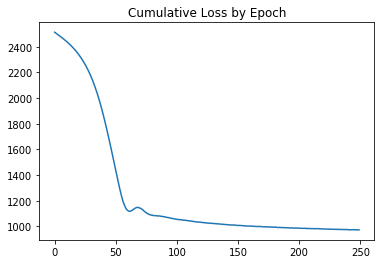

In [6]:
model = lstm_utils.TorchLSTM(
    train_x=train.drop(COLS_TO_IGNORE, axis=1),
    train_y=train[NORMALIZED_OPEN],
    test_x=test.drop(COLS_TO_IGNORE, axis=1),
    test_y=test[NORMALIZED_OPEN],
    n_layers=2,
    n_training_batches=1,
    n_epochs=250,
    hidden_shape=1000,
    dropout=0.1,
    learning_rate=.0001,
    seed=44,
)

model.fit()
prediction = model.prediction_df

In [7]:
PREDICTION = 'prediction'
DENORMALIZED_PREDICTION = 'denormalized_prediction'

res = test[COLS_TO_IGNORE].join(prediction)

res[DENORMALIZED_PREDICTION] = res[PREDICTION] * (df[OPEN_MAX] - df[OPEN_MIN]) + df[OPEN_MIN]
res.head()

,symbol,market_datetime,target_max_open,open,open_min,open_max,normalized_open,open_1,open_2,open_3,...,open_26,open_27,open_28,open_29,open_30,symbol_AA,symbol_JPM,symbol_KO,prediction,denormalized_prediction
3095,KO,2019-03-22,48.95,45.46,44.60,49.69,0.854617,0.182711,0.157171,0.186640,...,0.984283,1.000000,0.976424,0.937132,0.897839,0,0,1,0.624614,47.779287
3096,AA,2019-03-25,29.55,28.12,26.76,31.07,0.647332,0.542923,0.412993,0.403712,...,0.457077,0.475638,0.364269,0.183295,0.083527,1,0,0,0.867855,30.500455
3097,JPM,2019-03-25,116.43,99.59,101.76,108.20,2.277950,0.009317,0.268634,0.725155,...,0.110248,0.177019,0.029503,0.000000,0.049689,0,1,0,0.862209,107.312628
3098,KO,2019-03-25,48.95,45.86,44.60,49.69,0.854617,0.168959,0.182711,0.157171,...,0.412574,0.984283,1.000000,0.976424,0.937132,0,0,1,0.612266,47.716433
3099,AA,2019-03-26,29.55,28.14,26.76,31.07,0.647332,0.315545,0.542923,0.412993,...,0.452436,0.457077,0.475638,0.364269,0.183295,1,0,0,0.855078,30.445387


### Evaluate predictions

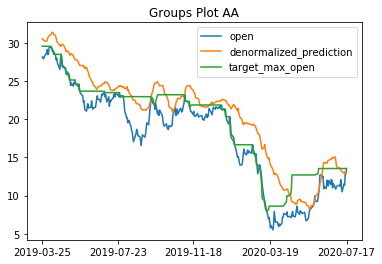

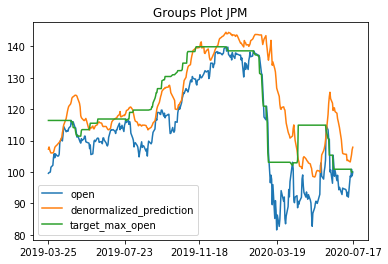

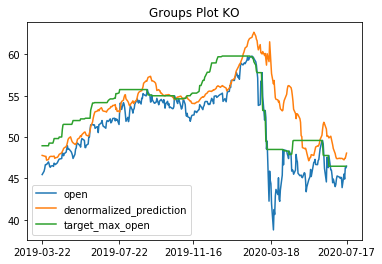

In [8]:
science_utils.plot_groups(res, SYMBOL, [OPEN, DENORMALIZED_PREDICTION, TARGET_MAX_OPEN])

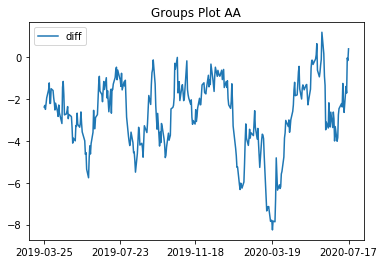

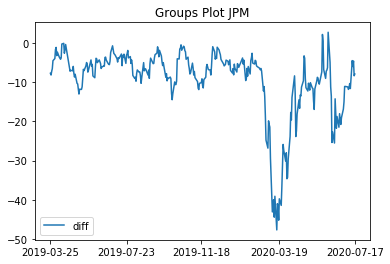

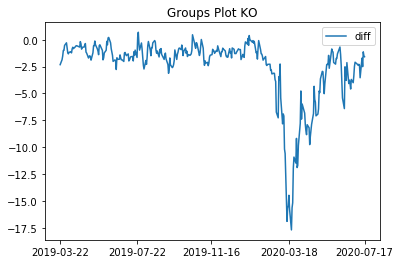

In [9]:
DIFF = 'diff'
res[DIFF] = res[OPEN] - res[DENORMALIZED_PREDICTION]
science_utils.plot_groups(res, SYMBOL, [DIFF])

### Get options data

In [10]:
date_start = datetime.datetime.today().date() - datetime.timedelta(days=1)
date_end = date_start
query = f'''
    with 
    stocks as (
      select
          market_datetime
        , symbol
        , close
      from td.stocks
      where market_datetime between '{date_start}' and '{date_end}'
          and symbol = 'KO'
      )
    , options as (
      select
          symbol
        , file_datetime
        , put_call = 'CALL'::text as put_call
        , strike
        , days_to_expiration
        , last
        , bid
        , ask
        , volatility
        , expiration_date_from_epoch
      from td.options
      where file_datetime between '{date_start}' and '{date_end}'
          and symbol = 'KO'
      )
    , volatility as (
      select
          symbol
        , file_datetime::date as file_datetime
        , strike
        , days_to_maturity
        , put_call::boolean
        , implied_volatility
      from td.black_scholes
      where file_datetime::date between '{date_start}' and '{date_end}'
          and symbol = 'KO'
      )
    , final as (
      select distinct
          s.market_datetime
        , s.symbol
        , s.close
        , o.put_call
        , o.strike
        , o.days_to_expiration as days_to_maturity
        , o.last
        , o.bid
        , o.ask
        , o.volatility
        , o.expiration_date_from_epoch
        , v.implied_volatility
      from stocks as s
      inner join options as o
        on  s.market_datetime = o.file_datetime
        and s.symbol = o.symbol
      left join volatility as v
        on  o.symbol = v.symbol
        and o.file_datetime = v.file_datetime
        and o.strike = v.strike
        and o.days_to_expiration = v.days_to_maturity
        and o.put_call = v.put_call
      order by
          s.market_datetime
        , s.symbol
        , o.put_call
        , o.strike
        , o.days_to_expiration
      )
    select *
    from final
    '''

options = utils.query_db(query=query)
options.head()

,market_datetime,symbol,close,put_call,strike,days_to_maturity,last,bid,ask,volatility,expiration_date_from_epoch,implied_volatility
0,2020-08-10,KO,47.72,False,20.0,11.0,0.02,0.00,0.06,29.0,2020-08-21 20:00:00,0.0
1,2020-08-10,KO,47.72,False,20.0,39.0,0.04,0.00,0.06,29.0,2020-09-18 20:00:00,0.0
2,2020-08-10,KO,47.72,False,20.0,102.0,0.02,0.00,0.07,29.0,2020-11-20 21:00:00,0.0
3,2020-08-10,KO,47.72,False,20.0,130.0,0.05,0.00,0.04,29.0,2020-12-18 21:00:00,0.0
4,2020-08-10,KO,47.72,False,20.0,158.0,0.02,0.02,0.04,29.0,2021-01-15 21:00:00,0.0


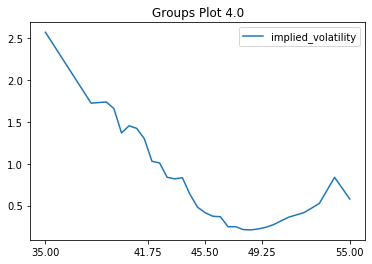

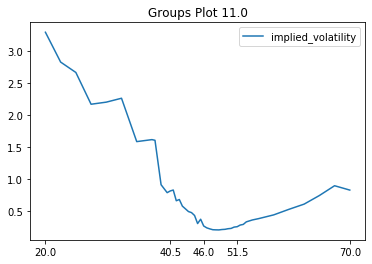

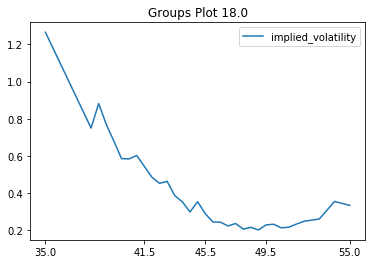

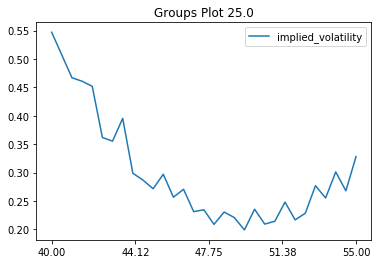

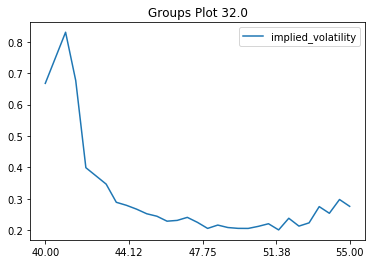

In [11]:
science_utils.plot_groups(
    df=options[options['put_call']],
    groups='days_to_maturity',
    lines=['implied_volatility'],
    xaxis_name='strike',
    n_plots=4,
)